In [12]:
# Twitter Sentiment Investing Strategy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
import matplotlib.ticker as mtick

plt.style.use('ggplot')
data_folder = 'C:/Users/Thomas/OneDrive/Desktop/ml-algo-trading/data'
sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']
sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

In [4]:
# Aggregate Monthly and calculate average sentiment for the month

aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())
aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

In [5]:
# Select Top 5 Stocks based on their cross-sectional ranking for each month

filtered_df = aggragated_df[aggragated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

In [6]:
# Extract the stocks to form portfolios with at the start of each new month

dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

In [7]:
# Download fresh stock prices for only selected/shortlisted stocks

stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-02-01')

prices_df

[*********************100%%**********************]  85 of 85 completed

1 Failed download:
['ATVI']: Exception('%ticker%: No timezone found, symbol may be delisted')


Adj Close                                                 \
                     A        AAL         AAP        AAPL        ABBV   
Date                                                                    
2021-01-04  116.384750  15.130000  145.845093  127.164169   92.173615   
2021-01-05  117.336311  15.430000  145.687561  128.736374   93.126717   
2021-01-06  120.553963  15.520000  154.104141  124.402924   92.322266   
2021-01-07  123.761810  15.380000  155.420441  128.647949   93.310364   
2021-01-08  124.644684  15.130000  157.635803  129.758347   93.800049   
...                ...        ...         ...         ...         ...   
2023-01-25  154.636414  16.260000  145.431961  141.071472  142.044601   
2023-01-26  155.103027  16.610001  143.978699  143.159805  141.669785   
2023-01-27  154.566940  16.430000  143.803162  145.118851  140.593307   
2023-01-30  150.645432  15.960000  146.182968  142.205154  139.987793   
2023-01-31  150.982986  16.139999  148.523758  143.487961  142.006165   

                                                                     ...  \
                   ABT        AEP        AES         ALB        AMD  ...   
Date                                                                 ...   
2021-01-04  103.105186  72.294289  21.144060  149.119400  92.300003  ...   
2021-01-05  104.380882  72.196754  21.853712  159.182465  92.769997  ...   
2021-01-06  104.163551  72.773064  22.727139  171.072571  90.330002  ...   
2021-01-07  105.174675  70.831390  22.499680  179.767838  95.160004  ...   
2021-01-08  105.467598  70.201881  23.127453  179.865540  94.580002  ...   
...                ...        ...        ...         ...        ...  ...   
2023-01-25  108.790169  87.726044  25.887283  268.642914  74.910004  ...   
2023-01-26  108.858772  88.334000  26.471926  277.039825  75.160004  ...   
2023-01-27  107.761063  88.409981  25.848946  279.290253  75.400002  ...   
2023-01-30  107.623863  88.220009  25.350561  269.634277  72.449997  ...   
2023-01-31  108.349129  89.255432  26.436573  279.022614  75.150002  ...   

             Volume                                                            \
                RCL     REGN       SLB      STZ         T      TMO       TSLA   
Date                                                                            
2021-01-04  5732800   911100   8743400  1202600  86700816  2220400  145914600   
2021-01-05  4029500   797700  16256600  1530200  83054520  2046700   96735600   
2021-01-06  3612500  1434700  19456300  1861700  73455520  2112300  134100000   
2021-01-07  3993700  1126600  14502400  2537100  71265359  2144400  154496700   
2021-01-08  3104200  1018800  11951900  1595400  72471656  2221700  225166500   
...             ...      ...       ...      ...       ...      ...        ...   
2023-01-25  2537300   584300   9053000  1069300  73582100  1238300  192734300   
2023-01-26  2552400   346400   8581500  1194700  47400900  1210800  234815100   
2023-01-27  3024400   417600   7669500  1304500  37094000  1110000  306590600   
2023-01-30  2638400   499500   6181100  1668800  37246000  1221500  230878800   
2023-01-31  2566700   816400   5951900  1502200  36575900  1799800  196813500   

                                         
                TSN         V       XOM  
Date                                     
2021-01-04  2177400  10318300  27764700  
2021-01-05  2297100   6869700  44035100  
2021-01-06  1942200   7206200  36484800  
2021-01-07  2969400  10967900  29528100  
2021-01-08  2672400   6513000  28628200  
...             ...       ...       ...  
2023-01-25  2133600   4729600  11914700  
2023-01-26  1651000   7043400  21019700  
2023-01-27  2699100  11382600  15179200  
2023-01-30  3362000   5677400  18672100  
2023-01-31  2940600  11294200  27861800  

[523 rows x 510 columns]

In [8]:
# Calculate Portfolio Returns with monthly rebalancing

print(prices_df['Adj Close'].head())

returns_df = np.log(prices_df['Adj Close']).diff().dropna()
print(returns_df)

portfolio_df = pd.DataFrame()
print(fixed_dates)

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    temp_df = returns_df.loc[start_date:end_date, cols].mean(axis=1).to_frame('portfolio_return')
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df
    
#     end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
#     cols = fixed_dates[start_date]
    
#     temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
#     portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
# portfolio_df

                     A    AAL         AAP        AAPL       ABBV         ABT  \
Date                                                                           
2021-01-04  116.384750  15.13  145.845093  127.164169  92.173615  103.105186   
2021-01-05  117.336311  15.43  145.687561  128.736374  93.126717  104.380882   
2021-01-06  120.553963  15.52  154.104141  124.402924  92.322266  104.163551   
2021-01-07  123.761810  15.38  155.420441  128.647949  93.310364  105.174675   
2021-01-08  124.644684  15.13  157.635803  129.758347  93.800049  105.467598   

                  AEP        AES         ALB        AMD  ...        RCL  \
Date                                                     ...              
2021-01-04  72.294289  21.144060  149.119400  92.300003  ...  70.720001   
2021-01-05  72.196754  21.853712  159.182465  92.769997  ...  72.550003   
2021-01-06  72.773064  22.727139  171.072571  90.330002  ...  72.199997   
2021-01-07  70.831390  22.499680  179.767838  95.160004  ...  73

,portfolio_return
Date,


In [9]:
# Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')
qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')
portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,


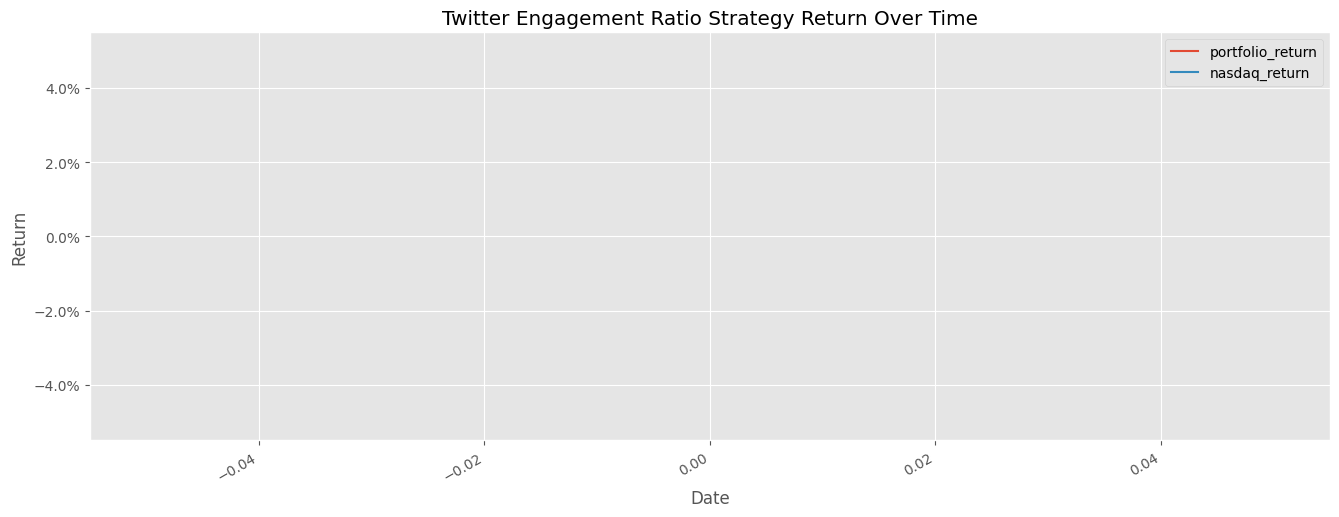

In [13]:
# Plot Data

portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)
portfolios_cumulative_return.plot(figsize=(16,6))
plt.title('Twitter Engagement Ratio Strategy Return Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()